In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import richdem as rd
import rioxarray as rio
from osgeo import gdal
from pyproj import CRS, Transformer
from rasterio.enums import Resampling
from rasterstats import zonal_stats

# Notebook 07b: Estimate mean catchment slopes

The [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/) website provides topogrpahic data for the whole Arctic region (north of 60 degrees) at a variety of resolutions. 

We would like to estimate mean slope for all the main catchments in the tidied RADR dataset. Because results for slope calculations based on raster data depend strongly on the grid resolution, we should ideally use the same resolution everywhere. As a starting point, we will try using the [100 m resolution grid](https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/100m/) from ArcticDEM, which is the most detailed dataset available as a single GeoTiff (rather than as multiple tiles). This dataset is quite large (about 8 GB compressed), so **the code here should be run on a large machine**.

**Note:** This notebook originally used [RichDEM](https://richdem.readthedocs.io/en/latest/) for the slope calculation, but this gave [strange results](https://github.com/r-barnes/richdem/issues/55) when run using the full resolution (100 m) dataset. Alternative approaches are explored in [notebook 07a](https://github.com/NIVANorge/BEST-Siberian/blob/main/code/07a_compare_slope_methods.ipynb). Based on those tests, the code here has been updated to use GDAL directly (which is more fiddly, but also seems more robust for large grids).

## 1. Download data

The raw data has been downloaded to the Hub here:

    shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_v3.0.tif
    
The easiest way to do this is using `wget` from the command line. First `cd` into the correct folder, then

    wget https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/100m/arcticdem_mosaic_100m_v3.0.tif
    
For testing and easy visualisation, I have also downloaded the [1 km resolution dataset](https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/1km/arcticdem_mosaic_1km_v3.0.tif) (which is only ~90 MB) to the same location using 

    wget https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/1km/arcticdem_mosaic_1km_v3.0.tif

In [2]:
# Choose dataset to work with (use 1 km data for develoment and testing)
data_res = 1000
in_ndv = -9999
out_ndv = 255
dst_dtype = "uint8"  # Rasterio dtypes: https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html

In [3]:
assert data_res in (1000, 100), "'data_res' must be 100 or 1000."

radr_cat_shp = (
    r"/home/jovyan/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
)
out_shp = f"/home/jovyan/shared/pan_arctic_data/arcticDEM/radr_cats_merged_{data_res}m_slopes.shp"

if data_res == 1000:
    dem_path = (
        r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_v3.0.tif"
    )
    proj_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_v3.0_proj.tif"
    slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_1km_v3.0_slopes.tif"
else:
    dem_path = (
        r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_v3.0.tif"
    )
    proj_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_v3.0_proj.tif"
    slp_path = r"/home/jovyan/shared/pan_arctic_data/arcticDEM/arcticdem_mosaic_100m_v3.0_slopes.tif"

In [4]:
def save_slope_rasterio(slope, template, slp_path, in_ndv, out_ndv, dtype):
    """Save a slope grid to disk using an existing rasterio dataset as a template.
    Makes it easier to apply compression etc. as the GDAL API is fiddly.

    Args
        slope:    Array-like. Values to save.
        template: Obj. Rioxarray dataset with the same dimensions, projection etc.
                  as the dataset you want to save. 'template' will be copied, then
                  values will be overwritten with the values in 'slope', and saved
        slp_path: Str. Path to output slope GeoTiff
        in_ndv:   Int. Value in 'slope' representing no data
        out_ndv:  Int. Value to use for no data in the output grid
        dtype:    Str. Rasterio data type (see the list here:
                    https://test2.biogeo.ucdavis.edu/rasterio/_modules/rasterio/dtypes.html

    Returns
        None. Array is saved to disk.
    """
    slope = slope.copy()
    slope[slope == in_ndv] = np.nan
    template = template.copy()
    slope = slope[np.newaxis, ...]
    template.values = slope
    template.rio.write_nodata(out_ndv, encoded=True, inplace=True)
    template.rio.to_raster(
        slp_path, compress="lzw", BIGTIFF="YES", dtype=dtype, tiled=True
    )

## 1. Explore data

In [5]:
# Read with rasterio
rds = rio.open_rasterio(dem_path, mask_and_scale=True)
print("Dataset size in memory:", rds.nbytes / 1e9, "GB.")
print("Dataset CRS:", rds.rio.crs)
print("Dataset transform:\n", rds.rio.transform())
rds

Dataset size in memory: 0.222 GB.
Dataset CRS: EPSG:3413
Dataset transform:
 | 1000.00, 0.00,-4000000.00|
| 0.00,-1000.00, 4100000.00|
| 0.00, 0.00, 1.00|


<xarray.DataArray (band: 1, y: 7500, x: 7400)>
[55500000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -4e+06 -3.998e+06 -3.998e+06 ... 3.398e+06 3.4e+06
  * y            (y) float64 4.1e+06 4.098e+06 4.098e+06 ... -3.398e+06 -3.4e+06
    spatial_ref  int64 0

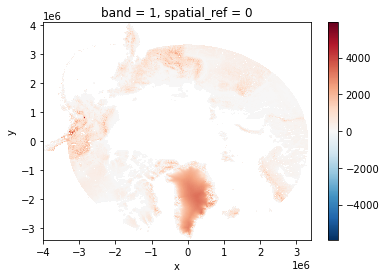

In [6]:
rds.squeeze().plot.imshow()

## 2. Simplistic slope calculation

If we ignore projection issues/distortion, slopes can be calculated easily using RichDEM or GDAL.

In [7]:
# # RichDEM. Fails with large grids - try GDAL instead
# dem = rd.LoadGDAL(dem_path)
# slope = rd.TerrainAttribute(dem, attrib="slope_degrees")
# print("Max. slope:", slope.max(), "degrees.")
# rd.rdShow(slope, axes=False, cmap="magma", figsize=(8, 5.5))
# del dem, slope

Max. slope: 57.046585 degrees.


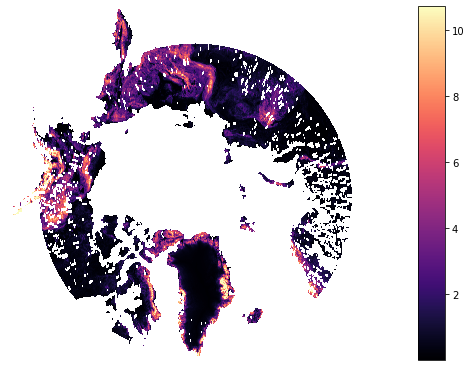

In [8]:
# Docs here: https://gdal.org/python/osgeo.gdal-module.html#DEMProcessingOptions
gdal.DEMProcessing(
    slp_path,
    dem_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="degree",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
slope = rd.LoadGDAL(slp_path)
print("Max. slope:", slope.max(), "degrees.")
rd.rdShow(slope, axes=False, cmap="magma", figsize=(8, 5.5))
del slope

## 3. Improved slope calculation

In order to accurately determine slopes, we need to use a projection that does not distort distances. All projections covering large areas involve some kind of distortion, and for any non-conformal projection the distortion varies with direction. Using a **conformal projection** is therefore a good idea, because at least then the distortion is constant in all directions. Nevertheless, for large areas it is necessary to apply a correction to account for different amounts of distortion in different regions.

[This post](https://gis.stackexchange.com/a/40464/2131) from GIS legend Bill Huber describes a sensible approach. The first step is to project the data to a **polar stereographic projection** (which is conformal), with **true scale at the pole**. For this projection, the scale distortion moving away from the pole is isotropic and equal to 
 
$$d = \frac{2}{1 + sin(lat)}$$
 
In other words, distances appear to be multiplied by $d$. If we consider slope defined as the ratio 
 
$$\frac{\Delta elevation}{\Delta distance}$$
 
then slopes computed in this projection are actually estimating
 
$$\frac{\Delta elevation}{d * \Delta distance}$$
 
To correct for this distortion, we first calculate slopes as rise/run (*not degrees*), then multiply by $d$. As a final step, we can obtain slopes in degrees from the corrected slope ratios, if desired.

The raw data are in `EPSG:3413`, which is polar stereographic, but with true scale at 70 degrees N (see the Proj.4 definition [here](https://epsg.io/3413)). The first step is therefore to reproject. In the code below, we keep the original cell size and apply bilinear resampling.

In [9]:
# Reproject to Polar Stereo with true scale at N Pole
dst_crs = "+proj=stere +lat_0=90 +lat_ts=90 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
rds = rds.rio.reproject(
    dst_crs,
    resolution=data_res,
    resampling=Resampling.bilinear,
)
rds.rio.to_raster(proj_path, compress="lzw", BIGTIFF="YES", tiled=True)
rds

<xarray.DataArray (band: 1, y: 7734, x: 7630)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -4.124e+06 -4.123e+06 ... 3.504e+06 3.505e+06
  * y            (y) float64 4.227e+06 4.226e+06 ... -3.505e+06 -3.506e+06
  * band         (band) int64 1
    spatial_ref  int64 0

In [10]:
# # Compute slopes as ratio rise:run using RichDEM
# # Currently not working - use GDAL instead
# dem = rd.LoadGDAL(proj_path)
# slope = rd.TerrainAttribute(dem, attrib="slope_riserun")
# del dem

Max. slope: 132.06633 percent.


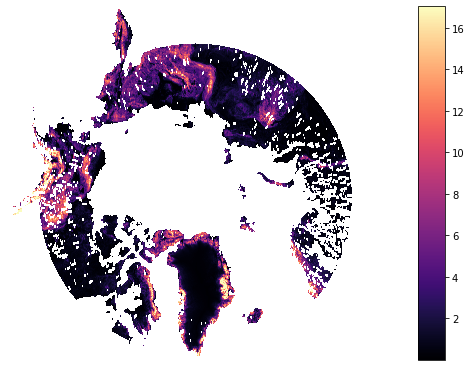

In [11]:
# Docs here: https://gdal.org/python/osgeo.gdal-module.html#DEMProcessingOptions
gdal.DEMProcessing(
    slp_path,
    proj_path,
    "slope",
    alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
    slopeFormat="percent",  # 'degree' or 'percent'
    creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
)
slope = rd.LoadGDAL(slp_path)
print("Max. slope:", slope.max(), "percent.")
rd.rdShow(slope, axes=False, cmap="magma", figsize=(8, 5.5));

40.36112535973785 89.99819721884336


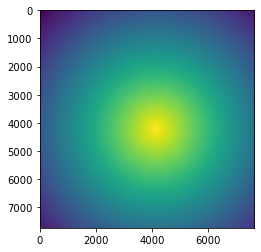

In [12]:
# Build a grid of lat values matching the ArcticDEM data
x, y = np.meshgrid(rds["x"], rds["y"])
crs_in = CRS.from_proj4(dst_crs)  # Polar stereographic with true scale at pole
crs_out = CRS.from_epsg(4326)  # lat/lon
transformer = Transformer.from_crs(crs_in, crs_out, always_xy=True)
lons, lats = transformer.transform(x, y)
del x, y, lons

assert lats.shape == slope.shape
print(lats.min(), lats.max())
plt.imshow(lats)

Max. slope: 55.0 degrees.


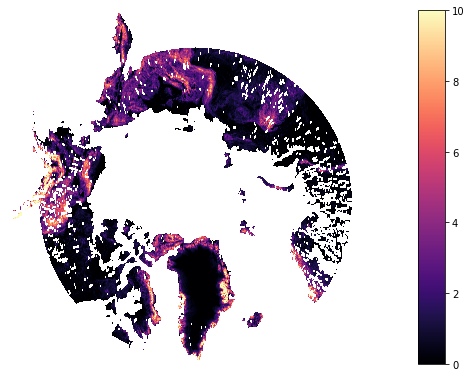

In [13]:
# Apply correction factor and convert to degrees
mask = slope == -9999
dfac = 2 / (1 + np.sin(np.deg2rad(lats)))
slope = dfac * (slope / 100)
slope = np.rad2deg(np.arctan(slope))
slope[mask] = np.nan
slope = np.rint(slope)
del mask, dfac

save_slope_rasterio(slope, rds, slp_path, in_ndv, out_ndv, dst_dtype)

print("Max. slope:", np.nanmax(slope), "degrees.")
rd.rdShow(slope, axes=False, cmap="magma", figsize=(8, 5.5))
del slope, lats, rds
os.remove(proj_path)

## 4. Zonal statistics

In [ ]:
%%time

# Zonal stats for catchments
stats = [
    "min",
    "percentile_25",
    "median",
    "percentile_75",
    "max",
    "mean",
    "std",
    "count",
]

cat_gdf = gpd.read_file(radr_cat_shp).to_crs(dst_crs)
idx_cols = [i for i in cat_gdf.columns if i != "geometry"]
cols = idx_cols + stats + ["geometry"]
res_df = pd.DataFrame(
    zonal_stats(
        vectors=cat_gdf,
        raster=slp_path,
        stats=stats,
    )
)

assert len(cat_gdf) == len(res_df)
for col in res_df.columns:
    cat_gdf[col] = res_df[col].values
cat_gdf = cat_gdf[cols]
cat_gdf.rename(
    {"percentile_25": "p25", "percentile_75": "p75"}, axis="columns", inplace=True
)
cat_gdf.to_file(out_shp, index=False)
cat_gdf.head()